# Importation des libraries

In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine

# Chargement des images

In [129]:
# Définir le chemin du répertoire où les fichiers sont extraits
extraction_directory = 'C:/Users/Mus/Downloads/'

# Corriger le chemin pour inclure le répertoire 'flowers' et lister son contenu
extraction_directory_updated = os.path.join(extraction_directory, 'flowers')

# Lister les fichiers dans le répertoire mis à jour
extracted_files_updated = os.listdir(extraction_directory_updated)

# Afficher les 10 premiers fichiers listés et le nombre total de fichiers
print("10 premiers fichiers :", extracted_files_updated[:10])
print("Nombre total de fichiers :", len(extracted_files_updated))

10 premiers fichiers : ['30-types-etonnants-de-fleurs-exotiques.webp', '3500121696_5b6a69effb_n.jpg', '3502085373_edc2c36992_n.jpg', '3502251824_3be758edc6_m.jpg', '3502615974_ef4bd13202_n.jpg', '3502632842_791dd4be18_n.jpg', '3502685880_f026400dce_n.jpg', '3502974120_9f1eceaf8b_n.jpg', '3510294699_bc4c72cb7d_n.jpg', '3512879565_88dd8fc269_n.jpg']
Nombre total de fichiers : 49


In [130]:
# Fonction pour ouvrir et visualiser une image à partir d'un chemin de fichier
def display_image(file_path):
    image = Image.open(file_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

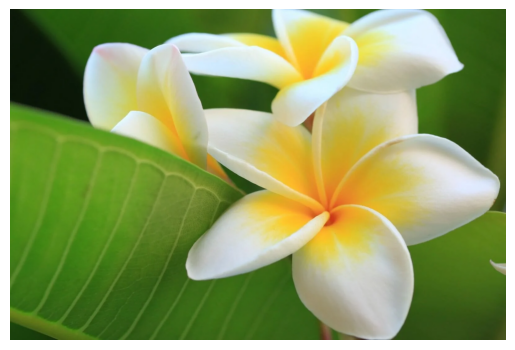

In [131]:
# Afficher la première image du répertoire
premiere_image_chemin = os.path.join(extraction_directory_updated, extracted_files_updated[0])
display_image(premiere_image_chemin)

In [137]:
# Chemin du répertoire où se trouvent vos images
image_directory = 'C:/Users/Mus/Downloads/flowers'

# Créer une liste des chemins de fichiers d'image avec les extensions spécifiées
image_paths_list = [file for file in glob.glob(os.path.join(image_directory, '*.*')) if file.endswith(('.jpg', '.png', '.jpeg', '.webp', '.jfif'))]

# Afficher la liste des chemins des fichiers image
print(image_paths_list)

['C:/Users/Mus/Downloads/flowers\\30-types-etonnants-de-fleurs-exotiques.webp', 'C:/Users/Mus/Downloads/flowers\\3500121696_5b6a69effb_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3502085373_edc2c36992_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3502251824_3be758edc6_m.jpg', 'C:/Users/Mus/Downloads/flowers\\3502615974_ef4bd13202_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3502632842_791dd4be18_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3502685880_f026400dce_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3502974120_9f1eceaf8b_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3510294699_bc4c72cb7d_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3512879565_88dd8fc269_n.jpg', 'C:/Users/Mus/Downloads/flowers\\3513200808_390f1d63a7_m.jpg', 'C:/Users/Mus/Downloads/flowers\\3516269489_cef36e87a6.jpg', 'C:/Users/Mus/Downloads/flowers\\3518608454_c3fd3c311c_m.jpg', 'C:/Users/Mus/Downloads/flowers\\3523398585_376960a611_m.jpg', 'C:/Users/Mus/Downloads/flowers\\3524204544_7233737b4f_m.jpg', 'C:/Users/Mus/Downloads/flowers\\3742155

# Extraction des caractéristiques d'images avec le modèle VGG16

In [138]:
# Charger le modèle VGG16 sans la couche de classification finale
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Fonction de prétraitement de l'image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

# Fonction d'extraction des caractéristiques
def extract_features(model, preprocessed_img):
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

# Listes pour stocker les caractéristiques extraites et les noms des images
all_features = []
all_image_names = []

# Boucle pour prétraiter chaque image, extraire ses caractéristiques, et les stocker
for img_path in image_paths_list:
    preprocessed_img = preprocess_image(img_path)
    features = extract_features(model, preprocessed_img)
    all_features.append(features)
    all_image_names.append(os.path.basename(img_path))

1/1 [==============================] - 3s 3s/step


# Système de recommandation

In [139]:
# Fonction de recommandation des images
def recommend_flowers_items_cnn(input_image_path, all_features, all_image_names, model, top_n=5):
    # Prétraiter l'image d'entrée et extraire ses caractéristiques
    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_features(model, preprocessed_img)

    # Calculer les similarités entre l'image d'entrée et toutes les autres images
    similarities = [1 - cosine(input_features, other_feature) for other_feature in all_features]
    
    # Trouver les indices des N images les plus similaires
    similar_indices = np.argsort(similarities)[-top_n:]

    # Exclure l'image d'entrée des résultats recommandés
    similar_indices = [idx for idx in similar_indices if idx != all_image_names.index(input_image_path)]

    # Afficher l'image d'entrée
    plt.figure(figsize=(15, 10))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(Image.open(input_image_path))
    plt.title("Input Image")
    plt.axis('off')

    # Afficher les images similaires recommandées
    for i, idx in enumerate(similar_indices[:top_n], start=1):
        image_path = os.path.join(':/Users/Mus/Downloads/flowers', all_image_names[idx])
        plt.subplot(1, top_n + 1, i + 1)
        plt.imshow(Image.open(image_path))
        plt.title(f"Recommendation {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Résultats

1/1 [==============================] - 3s 3s/step


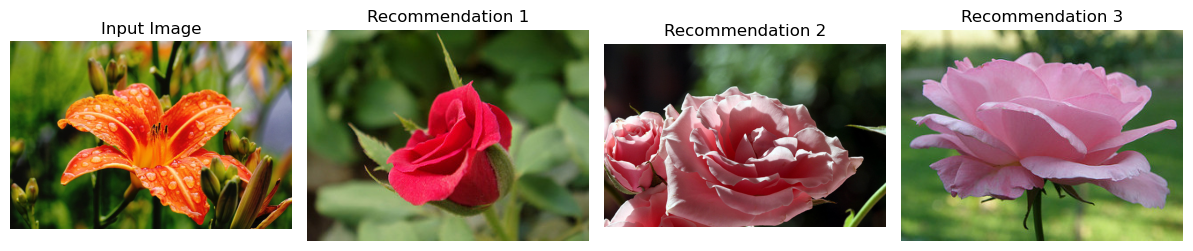

In [141]:
# Chemin du fichier de l'image d'entrée
input_image_path = 'C:/Users/Mus/Downloads/flowers\\flower-1146824_960_720.jpg'

# Recommander les 3 images les plus similaires à l'image d'entrée
recommend_flowers_items_cnn(input_image_path, all_features, image_paths_list, model, top_n=4)